# Flight Cancellation Prediction

A large travel agency has asked us to predict whether a flight will be canceled based on several factors. The agency can sell tickets for only three airlines (AA, UA, and DL) and would like to be able to advise its customers on which airline has the least risk of cancellation. Using the dataset provided:


1. Build a model to predict whether a flight will be canceled.
2. Write your own function that uses the model output to predict whether a future flight will be canceled.
3. Provide fully commented code and model output for your analysis.
4. Provide a recommendationon which airline is most reliable.


## 1. Feature Generation and Exploratory Data Analysis
### 1.1 Read the CSV data file as pandas DataFrame

In [1]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.pipeline import Pipeline
from sklearn import base
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('Data_PredictingFlightDelays.csv', header=None )
data.columns = ['Canceled', 'Month', 'DepartureTime', 'UniqueCarrier', 'SchedElapsedTime', 'ArrDelay', 'DepDelay', 'Distance']

# create a function to shuffle row index of data, so there won't be bia caused by order in later model fitting using cross validation
def shuffle(df, n=1, axis=0):     
    df = df.copy()
    df = df.reset_index().drop('index', axis= 1)
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
    return df

data = shuffle(data)

# create a new variable Hour for hour of the day:

def get_hour(x):
    try: # If departure time has >2 digits 
        return int(str(x)[:-2])
    except: # if departure time has only <=2 digits: the hour is 0, time is 0:xx
        return 0
    
data['Hour']= data['DepartureTime'].apply(get_hour)

### Target label: Canceled 

### Features: 
* Categorical feature:
  * **Month**: Month of the year 1,...,12
  * **UniqueCarrier**: AA, DL, UA
  * **DepartureTime**: extract a new feature, **Hour**, to determine the hour of flight (0 to 24)
* Numeric features: 
  * **SchedElapsedTime** 
  * **Distance** 

#### Excluded from features:  Arrival and departture delay in minutes (**ArrDelay and DepDelay**) 
* ArrDelay and DepDelay equal to zero for all cancelled flights (except for 5 cases of DepDelay), and >0 for flights not canceled. So they include outcome information in another sense and should not be used as features.
* These information will not be avaialbe for future prediction. 

### 1.2 Exploratory Data Analysis 
### 1.2.1 Histogram of continuous variables
First, plot the histogram of each continous variable (SchedElapsedTime, Distance, ArrDelay and DepDelay) by 'Canceled'. 

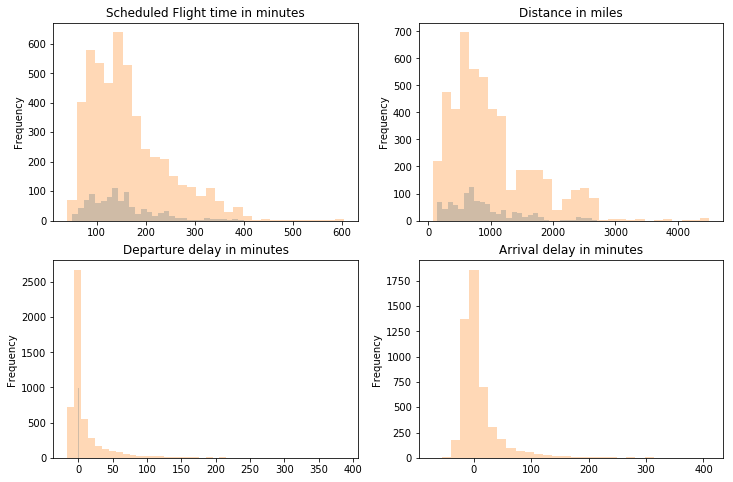

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

data.loc[data['Canceled']==1 ,'SchedElapsedTime'].plot.hist(bins= 30, ax=axes[0,0], alpha=.3, title= 'Scheduled Flight time in minutes')
data.loc[data['Canceled']==0 ,'SchedElapsedTime'].plot.hist( bins= 30, ax=axes[0,0], alpha=.3)

data.loc[data['Canceled']==1 ,'Distance'].plot.hist(bins= 30, ax=axes[0,1], alpha=.3, title= 'Distance in miles')
data.loc[data['Canceled']==0 ,'Distance'].plot.hist(bins= 30, ax=axes[0,1], alpha=.3 )

data.loc[data['Canceled']==1 ,'ArrDelay'].plot.hist(bins= 30, ax=axes[1,1], alpha=.3, title= 'Arrival delay in minutes')
data.loc[data['Canceled']==0 ,'ArrDelay'].plot.hist(bins= 30, ax=axes[1,1], alpha=.3 )

data.loc[data['Canceled']==1 ,'DepDelay'].plot.hist(bins= 40, ax=axes[1,0], alpha=.3, title= 'Departure delay in minutes' )
data.loc[data['Canceled']==0 ,'DepDelay'].plot.hist(bins= 40, ax=axes[1,0], alpha=.3  )

Orange histogram shows flights not canceled (Canceled =0) while the grew histogram shows canceled flights(Canceled=1).

                  SchedElapsedTime  Distance
SchedElapsedTime          1.000000  0.982335
Distance                  0.982335  1.000000


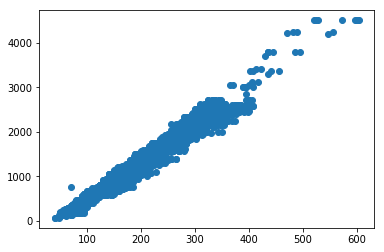

In [4]:
print(data[['SchedElapsedTime','Distance']].corr())
plt.scatter(data['SchedElapsedTime'], data['Distance'])

### Findings:
* SchedElapsedTime and Distance both have a distribution skewed to the right. 
* Arrival and departure delay only have values when flights were not canceled (Cancel=0). So we should not include them as features.
* 'SchedElapsedTime'and 'Distance' are highly correlated (correlation = 0.98). I'll choose only Distance as a feature in predition model to avoild multicollinearity in model. 

### 1.2.2 Frequency table of categorical features by Canceled

In [5]:
data.groupby(['Canceled','UniqueCarrier']).size().unstack()

UniqueCarrier,AA,DL,UA
Canceled,,,
0,1983,1499,1518
1,493,189,318


In [6]:
cancel_by_month = data.groupby(['Canceled','Month']).size().unstack()
cancel_by_month

Month,1,2,3,4,5,6,7,8,9,10,11,12
Canceled,,,,,,,,,,,,
0,416,431,388,441,450,429,396,438,413,435,390,373
1,123,140,129,147,65,65,84,71,38,16,33,89


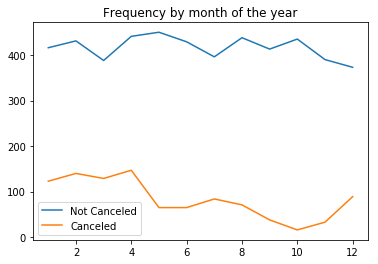

In [7]:
plt.plot(cancel_by_month.iloc[0], label= 'Not Canceled')
plt.plot(cancel_by_month.iloc[1], label= 'Canceled')
plt.legend(loc=3)
plt.title('Frequency by month of the year')

In [8]:
cancel_by_hour= data.groupby(['Canceled','Hour']).size().unstack()

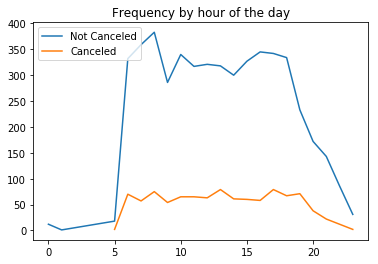

In [9]:
plt.plot(cancel_by_hour.iloc[0], label= 'Not Canceled')
plt.plot(cancel_by_hour.iloc[1], label= 'Canceled')
plt.legend(loc=2)
plt.title('Frequency by hour of the day')

### Findings:
* No obvious increasing or decreasing trend when using Month or Hour as numeric variable, so it is reasonable to use them as categorical variable
* Very few flights at 12AM, 1AM, 5AM. No flights at 2AM, 3AM, 4AM at all. Most flights were during day time.

### 1.3 Feature Generation - One Hot Encoding
use OneHotEncoder, LabelEncoder from sklearn to convert categorical variables (UniqueCarrier, Month and Hour) into binary variables to use for model fitting.

* Build a custom transformer that will transform data to features we want:

In [12]:
# (base.BaseEstimator, base.TransformerMixin)-> this class will have .fit(),.fit_transform( mothods

class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, categorical_variables, numeric_variables): 
        # parameters taken by the transformer: a list of categorical_variables, a list of numeric_variables
        self.categorical_variables = categorical_variables  # We will need these in transform()
        self.numeric_variables     = numeric_variables
    
    def fit(self, X, y=None):
        # Create empty list to store encode fit
        self.label_encode = [] 
        self.OneHot_encode = []
        
        # fit LabelEncoder and OneHotEncoder to data
        for i, column in enumerate(self.categorical_variables):
            LE = LabelEncoder()                 # encode categorical variables as numeric
            OHE = OneHotEncoder( sparse=False)  # do one hot encoding
            OHE.fit(LE.fit_transform( X[column]).reshape(-1,1))
            self.label_encode.append( LE )    
            self.OneHot_encode.append( OHE )  
        return self
    
    def transform(self, X):
        X = X.reset_index() 
        df_cat = []  # empty list to store transformation result for each categorical variable
        
        # use LabelEncoder and OneHotEncoder to transform data
        for i, column in enumerate(self.categorical_variables):
            df_feature = self.OneHot_encode[i].transform(self.label_encode[i].transform( X[column]).reshape(-1,1))
            df_feature = pd.DataFrame(df_feature)
            df_feature.columns = [column  +'_'+str(x) for x in list(self.label_encode[i].classes_)]
            df_cat.append(df_feature)
            
        # Merge these dummary variables with numeric features: 
        df_numeric = X[self.numeric_variables]
        X = pd.concat([df_numeric]+ df_cat, axis=1) 
        
        return X 

* Transform data, 
* list feature names
* look at the transformed feature matrix

In [206]:
CT = ColumnSelectTransformer(categorical_variables=['UniqueCarrier','Month', 'Hour'], 
                                numeric_variables=['Distance'])
df_feature = CT.fit_transform(data)
columns = list(df_feature.columns)
print(columns)
df_feature.head()

['Distance', 'UniqueCarrier_AA', 'UniqueCarrier_DL', 'UniqueCarrier_UA', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Hour_0', 'Hour_1', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23']


,Distance,UniqueCarrier_AA,UniqueCarrier_DL,UniqueCarrier_UA,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,679,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,214,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1605,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,235,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,413,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Build a model to predict whether a flight will be canceled.
Build prediction models using features generated above.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

### 2.1 Split data into training set and test set
Split data into traing set(N=5000) and test set(N=1000): 

In [364]:
X =  data.drop('Canceled', axis=1)
y = data['Canceled']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size= 1000, random_state=42)

### 2.2 Fit different classifiers to training data and plot ROC curve using test data

Random Forest: Train Accuracy 0.8496 , Test Accuracy 0.816
Confusion matrix of test data:
[[803  16]
 [168  13]]
Decision Tree: Train Accuracy 0.9034 , Test Accuracy 0.773
Confusion matrix of test data:
[[730  89]
 [138  43]]
Logistic Regression: Train Accuracy 0.8362 , Test Accuracy 0.819
Confusion matrix of test data:
[[819   0]
 [181   0]]
Regularized Logistic Regression: Train Accuracy 0.8362 , Test Accuracy 0.819
Confusion matrix of test data:
[[819   0]
 [181   0]]
Naive Bayes: Train Accuracy 0.5212 , Test Accuracy 0.547
Confusion matrix of test data:
[[411 408]
 [ 45 136]]


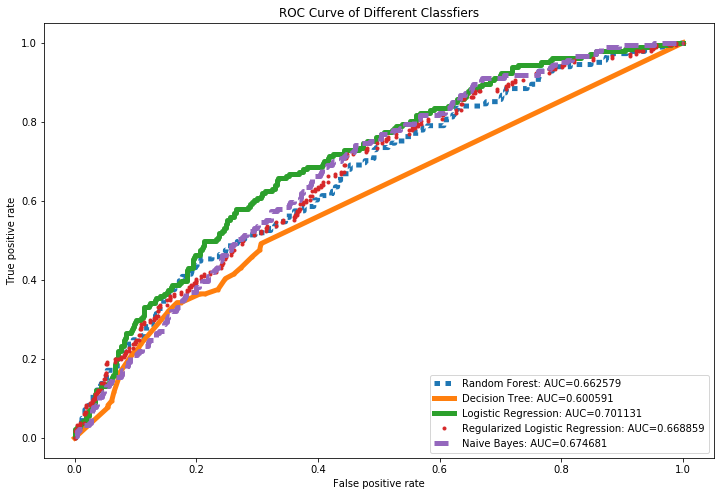

In [428]:
#max_depth= 10, n_estimators = 10, max_features= 10
# name -> (line format, classifier)
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

CLASS_MAP ={
    'Logistic Regression': ('-', LogisticRegression() ),
    'Regularized Logistic Regression': ('.', GridSearchCV(LogisticRegression(penalty= 'l2'), {'C':np.logspace(-2, 2.0, num=10)}) ),
    'Naive Bayes' :('--', GaussianNB() ),
    'Decision Tree' :('.-',DecisionTreeClassifier(min_samples_split=10) ) ,
    'Random Forest': (':', RandomForestClassifier(min_samples_split=20)),
}

plt.figure(figsize= (12,8))
for name, (line_fmt, clf) in CLASS_MAP.items():
    # train model
    model = Pipeline([
        ('ColSelect', CT ),# ColumnSelectTransformer
        ('clf', clf)       # classifier
    ])
    
    model.fit( X_train, y_train)
    # predict probability on test data
    preds = model.predict_proba(X_test)
    pred = pd.Series(preds[:, 1])
    
    # Calcualte FPR, TPR for plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    auc_score = auc(fpr, tpr)
    label = '%s: AUC=%f' %(name, auc_score)
    plt.plot(fpr, tpr, line_fmt, linewidth=5, label= label)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    print(name + ': Train Accuracy', accuracy_score(y_train, train_pred) , #sum(train_pred== y_train)/len(y_train),
          ', Test Accuracy', accuracy_score(y_test, test_pred))

    #print('Confusion matrix of train data:')
    #print(confusion_matrix(y_train, train_pred))
    print('Confusion matrix of test data:')
    print(confusion_matrix(y_test, test_pred))
plt.legend(loc= 'lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve of Different Classfiers')

In [366]:
#accuracy of predicting all flights to be not canceled:
sum(y_test==0)/len(y_test)

0.81899999999999995

### Findings: 
* All models have similar AUC. 
* All accuracy are similar to just predicting all flights not canceled(0.819). 
    * Random ForestTest Accuracy 0.816
    * Decision TreeTest Accuracy 0.81
    * Logistic RegressionTest Accuracy 0.819
    * Regularized Logistic RegressionTest Accuracy 0.819
    * Naive BayesTest Accuracy 0.547
* Looking at the confusion matrix, we can see that logistic regression is actually predicting Canceled =0 for all, which is not a good choice.
* I choose random forest classifier to be the final prediction model. This final model is very good but that's the best model using current features. 

### 2.3 Fit the final model using all data:
Build a pipeline to do automatic feature transformation and model fitting.  

In [419]:
from sklearn.pipeline import Pipeline
CT = ColumnSelectTransformer(categorical_variables=['UniqueCarrier','Month', 'Hour'], 
                                numeric_variables=['Distance'])
#clf = LogisticRegression()
clf = RandomForestClassifier(min_samples_split=20)
pipe = Pipeline([
        ('ColSelect', CT ),# ColumnSelectTransformer
        ('clf', clf)       # classifier
    ])

pipe.fit(data, data['Canceled'])

Pipeline(steps=[('ColSelect', ColumnSelectTransformer(categorical_variables=['UniqueCarrier', 'Month', 'Hour'],
            numeric_variables=['Distance'])), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=Non...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [420]:
pipe.named_steps['clf'].feature_importances_

array([  3.16604449e-01,   2.82240984e-02,   2.77523600e-02,
         2.14406690e-02,   1.94755014e-02,   2.94967781e-02,
         2.44804980e-02,   3.41326765e-02,   1.30426311e-02,
         1.28245833e-02,   2.19265716e-02,   1.29954337e-02,
         1.69805591e-02,   2.69855070e-02,   1.57258828e-02,
         1.66998637e-02,   2.63454192e-04,   1.84912906e-04,
         4.18891983e-03,   2.26621198e-02,   2.47465713e-02,
         2.47031857e-02,   1.54477402e-02,   2.07629973e-02,
         2.26076385e-02,   2.27734415e-02,   2.04915068e-02,
         2.60809708e-02,   1.92544765e-02,   2.14155002e-02,
         1.69491824e-02,   2.81745559e-02,   2.63331078e-02,
         1.62801614e-02,   1.30816942e-02,   1.04658520e-02,
         4.34394726e-03])

### Examine the variance importance:

In [421]:
importance = pipe.named_steps['clf'].feature_importances_
importance = pd.DataFrame(importance, index= columns, columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in clf.estimators_], axis=0)

importance

,Importance,Std
Distance,0.316604,0.023634
UniqueCarrier_AA,0.028224,0.013056
UniqueCarrier_DL,0.027752,0.010602
UniqueCarrier_UA,0.021441,0.014254
Month_1,0.019476,0.006662
Month_2,0.029497,0.012345
Month_3,0.024480,0.008518
Month_4,0.034133,0.010115
Month_5,0.013043,0.005501
Month_6,0.012825,0.008902


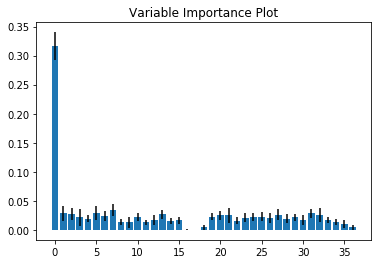

In [422]:
x_ = range(importance.shape[0])
y_ = importance.ix[:, 0]
yerr = importance.ix[:, 1]

plt.bar(x_, y_, yerr=yerr, align="center")
plt.title('Variable Importance Plot')
plt.show()

### Interpretation:
Distance is the most important feature in the final model to predict flight cancellation.

### Interpretation: 
*  The logistic regression coefficients give the change in the log odds of the outcome for a one unit increase in the predictor variable.
* can get odds-ratio by exponentiating the coefficients.
* Positive coefficient (odds ratio >1) suggest the odds of canceled is higher if that feature =0 compared with feature =1.

## 3. Use the model output to predict whether a future flight will be canceled.
* Ramdomly sample 10 rows from data to use as test data and show how prediction can be done for future new data.

In [424]:
# Randomly sample 10 rows from data for test prediction
test_num = 10
test = data.sample(test_num )
test.head()

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance,Hour
2966,0,12,920,UA,156,-18,-1,783,9
20,1,7,2059,UA,130,0,0,719,20
98,1,9,720,AA,115,0,0,631,7
4112,0,5,1105,UA,218,15,31,1671,11
5350,0,8,1245,AA,215,-8,-5,1558,12


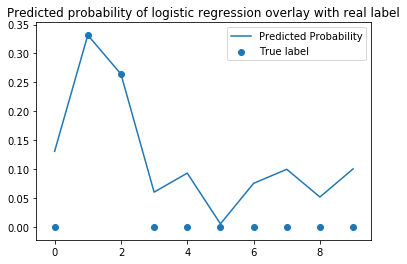

In [429]:
prob = pipe.predict_proba(test)[:,1]
plt.plot(prob, label= 'Predicted Probability')
plt.scatter( range(test_num ), list(test['Canceled']* prob) , label= 'True label')
plt.legend(loc=1)
plt.title('Predicted probability of logistic regression overlay with real label')

Interpretation: 
* Logistic regression predict all records to be Canceled= 0. 
* In read prediction, we will not have the true value. 
* For this case, when we overlay true Canceled(dots above 0), not canceled(dots at 0) on the predicted probability plot. 
* Canceled flights do have higher predicted probability.

## 4. Provide a recommendationon which airline is most reliable.

### 1. Delta(DL) has the lowest overall probability of canceled flight

In [392]:
c = data.groupby(['UniqueCarrier', 'Canceled']).size().unstack()
c['proportion'] = c[1]/(c[0]+ c[1])
c

Canceled,0,1,proportion
UniqueCarrier,,,
AA,1983,493,0.199111
DL,1499,189,0.111967
UA,1518,318,0.173203


### 2. Delta(DL) is also the carrier with lowest probabilities of canceled flight by month

In [277]:
grp  =  data[['Canceled', 'UniqueCarrier','Month']].groupby(['Month','UniqueCarrier' ])
m = grp.agg({'mean', 'count'}).unstack()
m

Canceled                                        
                 count                mean                    
UniqueCarrier       AA   DL   UA        AA        DL        UA
Month                                                         
1                  211  143  185  0.213270  0.202797  0.264865
2                  228  157  186  0.311404  0.133758  0.258065
3                  230  134  153  0.347826  0.111940  0.222222
4                  318  131  139  0.358491  0.083969  0.158273
5                  201  140  174  0.169154  0.035714  0.149425
6                  192  138  164  0.114583  0.137681  0.146341
7                  170  127  183  0.088235  0.181102  0.251366
8                  239  145  125  0.158996  0.117241  0.128000
9                  177  144  130  0.107345  0.083333  0.053846
10                 170  140  141  0.052941  0.007143  0.042553
11                 178  122  123  0.067416  0.098361  0.073171
12                 162  167  133  0.209877  0.143713  0.233083

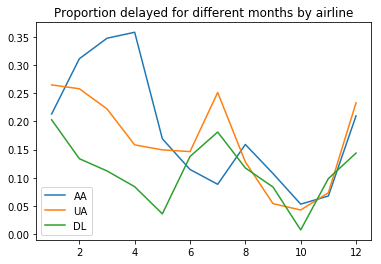

In [278]:
plt.plot( m['Canceled']['mean']['AA'], label='AA')
plt.plot( m['Canceled']['mean']['UA'], label='UA')
plt.plot( m['Canceled']['mean']['DL'], label='DL')
plt.legend(loc=3)
plt.title('Proportion delayed for different months by airline')

* The green line for DL is has the lowest probability based on current data.

### 3. Delta(DL) is also the carrier with lowest probabilities of canceled flight by hour of the day

In [358]:
grp_h  =  data[['Canceled', 'UniqueCarrier','Hour']].groupby(['Hour','UniqueCarrier' ])
h = grp_h.agg({'mean', 'count'}).unstack()
h

Canceled                                         
                   mean                      count              
UniqueCarrier        AA        DL        UA     AA     DL     UA
Hour                                                            
0              0.000000  0.000000  0.000000    3.0    8.0    1.0
1              0.000000       NaN       NaN    1.0    NaN    NaN
5              0.000000  0.111111  0.333333    8.0    9.0    3.0
6              0.195122  0.125000  0.180000  164.0   88.0  150.0
7              0.194245  0.082759  0.136364  139.0  145.0  132.0
8              0.168367  0.129310  0.184932  196.0  116.0  146.0
9              0.183007  0.106796  0.178571  153.0  103.0   84.0
10             0.203593  0.100917  0.155039  167.0  109.0  129.0
11             0.203947  0.096000  0.209524  152.0  125.0  105.0
12             0.168750  0.137615  0.182609  160.0  109.0  115.0
13             0.263158  0.113208  0.183333  171.0  106.0  120.0
14             0.215569  0.138298  0.120000  167.0   94.0  100.0
15             0.201087  0.085714  0.142857  184.0  105.0   98.0
16             0.191860  0.105263  0.112245  172.0  133.0   98.0
17             0.200000  0.149123  0.204082  160.0  114.0  147.0
18             0.204819  0.134615  0.145038  166.0  104.0  131.0
19             0.239437  0.181818  0.260417  142.0   66.0   96.0
20             0.195402  0.080645  0.262295   87.0   62.0   61.0
21             0.192308  0.049180  0.173077   52.0   61.0   52.0
22             0.115385  0.090909  0.140000   26.0   22.0   50.0
23             0.000000  0.000000  0.111111    6.0    9.0   18.0

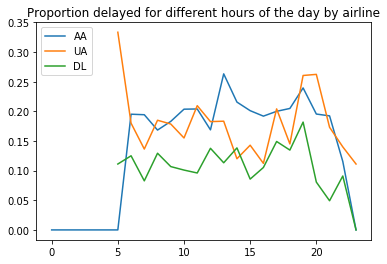

In [360]:
plt.plot( h['Canceled']['mean']['AA'], label='AA')
plt.plot( h['Canceled']['mean']['UA'], label='UA')
plt.plot( h['Canceled']['mean']['DL'], label='DL')
plt.legend(loc=0)
plt.title('Proportion delayed for different hours of the day by airline')

### Conclusion: The agency should advise its customers that Delta airline has the least risk of cancellation